Here we check if drivers identified by models overlap DNase I footprints identified by Vierstra et al. 2020. 

In [1]:
import os
import sys
from collections import defaultdict

import liftover
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from genomic_utils.variant import Variant

sys.path.append("..")
import evaluation_utils

In [2]:
GEUVADIS_COUNTS_PATH = "../../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"

FOOTPRINT_DIRS = [
    "/data/yosef3/scratch/ruchir/data/vierstra2020/per_dataset/GM06990-DS7748",
    "/data/yosef3/scratch/ruchir/data/vierstra2020/per_dataset/GM12865-DS12436",
] # one directory per sample
FPR_THRESHOLD = "0.01"

LIFTOVER_CHAIN_PATH = "/data/yosef3/scratch/ruchir/data/genomes/liftOver/hg19ToHg38.over.chain.gz"

DRIVERS_CSV = "drivers.csv"

In [3]:
class Region():
    def __init__(self, chrom: str, start: int, end: int):
        self.chrom = chrom.replace("chr", "")
        self.start = int(start) # inclusive, 0-indexed
        self.end = int(end) # exclusive, 1-indexed

    def __len__(self):
        return self.end - self.start
    
    def overlaps_variant(self, variant: Variant) -> bool:
        if self.chrom != variant.chrom:
            return False
        # variant.pos is 1-indexed
        return self.start < variant.pos <= self.end
    
    def merge(self, other_region: "Region") -> "Region":
        if self.chrom != other_region.chrom:
            raise ValueError("Cannot merge regions on different chromosomes")
        new_start = min(self.start, other_region.start)
        new_end = max(self.end, other_region.end)
        return Region(self.chrom, new_start, new_end)
    
    def fraction_overlap(self, other_region: "Region") -> float:
        if self.chrom != other_region.chrom:
            return 0.0
        overlap_start = max(self.start, other_region.start)
        overlap_end = min(self.end, other_region.end)
        if overlap_start >= overlap_end:
            return 0.0
        overlap_length = overlap_end - overlap_start
        return overlap_length / len(self)

    def __str__(self):
        return f"{self.chrom}:{self.start}-{self.end}"

In [4]:
def merge_regions(regions: set[Region]) -> set[Region]:
    assert len(set([region.chrom for region in regions])) == 1
    sorted_regions = sorted(regions, key=lambda region: region.start)
    merged_regions = []
    current_region = sorted_regions[0]
    for i in range(1, len(sorted_regions)):
        if current_region.end >= sorted_regions[i].start:
            current_region = current_region.merge(sorted_regions[i])
        else:
            merged_regions.append(current_region)
            current_region = sorted_regions[i]
    merged_regions.append(current_region)
    return set(merged_regions)


def check_regions_disjoint(regions: set[Region]) -> bool:
    # This function assumes that all regions are on the same chromosome
    assert len(set([region.chrom for region in regions])) == 1
    sorted_regions = sorted(regions, key=lambda region: region.start)
    for i in range(len(sorted_regions) - 1):
        if sorted_regions[i].end > sorted_regions[i + 1].start:
            print(f"Overlapping regions: {sorted_regions[i]} and {sorted_regions[i + 1]}")
            return False
    return True


def get_footprints_by_chromosome() -> dict[str, set[Region]]:
    footprints_by_chrom = defaultdict(set)
    for footprint_dir in FOOTPRINT_DIRS:
        bed_path = os.path.join(footprint_dir, f"interval.all.fps.{FPR_THRESHOLD}.bed")
        for line in open(bed_path):
            chrom, start, end, *_ = line.strip().split("\t")
            region = Region(chrom, start, end)
            footprints_by_chrom[region.chrom].add(region)
    
    # Merge overlapping regions
    for chrom, regions in footprints_by_chrom.items():
        footprints_by_chrom[chrom] = merge_regions(regions)
    
    # Check that all regions are disjoint
    for chrom, regions in footprints_by_chrom.items():
        if not check_regions_disjoint(regions):
            raise ValueError(f"Footprints on {chrom} are not disjoint")

    return footprints_by_chrom

In [5]:
footprints_by_chrom = get_footprints_by_chromosome()

# Get background probability of a position overlapping a footprint by position to TSS

In [6]:
def get_training_genes():
    gene_to_class_map = evaluation_utils.get_gene_to_class_map()
    train_genes = {g for g, c in gene_to_class_map.items() if c != "unseen"}
    assert len(train_genes) == 400
    return train_genes

In [7]:
counts_df = pd.read_csv(GEUVADIS_COUNTS_PATH, index_col="our_gene_name")
training_genes = sorted(get_training_genes())
counts_df = counts_df.loc[training_genes]

# Liftover TSS to hg38
converter = liftover.ChainFile(LIFTOVER_CHAIN_PATH, one_based=True)
hg38_chroms, hg38_tss_l = [], []
for hg19_chrom, hg19_tss in zip(counts_df["Chr"], counts_df["Coord"]):
    hg38_liftover = converter[hg19_chrom][hg19_tss]
    assert len(hg38_liftover) == 1
    hg38_chrom, hg38_tss = hg38_liftover[0][0], hg38_liftover[0][1]
    hg38_chroms.append(hg38_chrom)
    hg38_tss_l.append(hg38_tss)

counts_df["hg38_chrom"] = hg38_chroms
counts_df["hg38_tss"] = hg38_tss_l

In [8]:
def compute_fraction_overlap(query_regions: list[Region], footprints: set[Region]) -> np.ndarray:
    # Footprints are assumed to be disjoint
    sorted_fps = sorted(footprints, key=lambda region: region.start)
    sorted_fp_starts = [fp.start for fp in sorted_fps]
    sorted_fp_ends = [fp.end for fp in sorted_fps]
    assert sorted_fp_ends == sorted(sorted_fp_ends)

    qr_starts = [query_region.start for query_region in query_regions]
    qr_ends = [query_region.end for query_region in query_regions]

    # lower bound: first footprint whose end is > query_region.start
    # upper bound: first footprint whose start is > query_region.end
    lows = np.searchsorted(sorted_fp_ends, qr_starts, side="right")
    highs = np.searchsorted(sorted_fp_starts, qr_ends, side="left")
    overlap_fractions = np.zeros(len(query_regions), dtype=np.float32)
    for i in range(len(query_regions)):
        start_idx = lows[i]
        end_idx = highs[i]
        for j in range(start_idx, end_idx):
            overlap_fractions[i] += query_regions[i].fraction_overlap(sorted_fps[j])
    return overlap_fractions

In [9]:
context_size = 384 * 128
query_size = 250

bkg_overlap_fractions = []
for hg38_chrom, hg38_tss in zip(counts_df["hg38_chrom"], counts_df["hg38_tss"]):
    chrom_foorprints = footprints_by_chrom[hg38_chrom.replace("chr", "")]
    upstream_query_regions = [
        Region(hg38_chrom, hg38_tss - query_start - query_size, hg38_tss - query_start)
        for query_start in range(0, context_size // 2, query_size)
    ]
    downstream_query_regions = [
        Region(hg38_chrom, hg38_tss + query_start, hg38_tss + query_start + query_size)
        for query_start in range(0, context_size // 2, query_size)
    ]
    upstream_overlap_fractions = compute_fraction_overlap(upstream_query_regions, chrom_foorprints)
    downstream_overlap_fractions = compute_fraction_overlap(downstream_query_regions, chrom_foorprints)
    overlap_fractions = 0.5 * (upstream_overlap_fractions + downstream_overlap_fractions)
    bkg_overlap_fractions.append(overlap_fractions)

bkg_overlap_fractions = np.array(bkg_overlap_fractions)
mean_bkg_overlap_fractions = np.mean(bkg_overlap_fractions, axis=0)
std_bkg_overlap_fractions = np.std(bkg_overlap_fractions, axis=0)
se_bkg_overlap_fractions = std_bkg_overlap_fractions / np.sqrt(len(bkg_overlap_fractions))

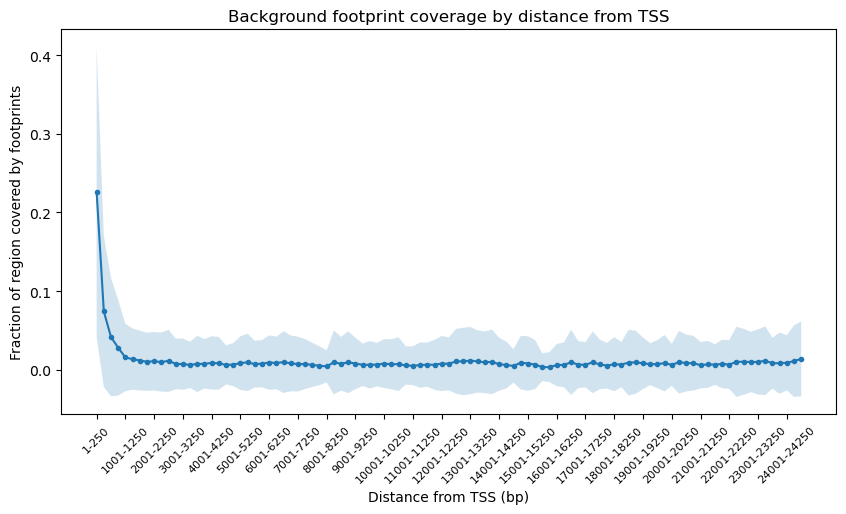

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(mean_bkg_overlap_fractions))
y = mean_bkg_overlap_fractions
ax.plot(x, y, marker="o", markersize=3)
ax.fill_between(
    x=x,
    y1=y - std_bkg_overlap_fractions,
    y2=y + std_bkg_overlap_fractions,
    alpha=0.2,
)

bin_labels = [
    f"{i * query_size + 1}-{(i + 1) * query_size}"
    for i in range(len(mean_bkg_overlap_fractions))
]
tick_positions = x[::4]
tick_labels = bin_labels[::4]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, size=8)

ax.set_xlabel("Distance from TSS (bp)")
ax.set_ylabel("Fraction of region covered by footprints")
ax.set_title("Background footprint coverage by distance from TSS")
plt.savefig("../figures/background_footprint_coverage.pdf", bbox_inches="tight")
plt.show()

# Annotate drivers

In [11]:
drivers_df = pd.read_csv(DRIVERS_CSV)
drivers_df["hg19_driver"] = drivers_df["driver"].apply(Variant.create_from_str)

# Liftover to hg38
converter = liftover.ChainFile(LIFTOVER_CHAIN_PATH, one_based=True)
hg38_drivers = []
for hg19_driver in drivers_df["hg19_driver"]:
    hg38_liftover = converter[hg19_driver.chrom][hg19_driver.pos]
    if len(hg38_liftover) == 0:
        hg38_drivers.append(None)
        print(f"WARNING: {hg19_driver} could not be lifted over")
    else:
        assert len(hg38_liftover) == 1
        (hg38_chrom, hg38_pos, _) = hg38_liftover[0]
        # Our analysis does not require knowing the ref/alt bases in hg38, so we can just use the hg19 ones
        hg38_driver = Variant(hg38_chrom, hg38_pos, hg19_driver.ref, hg19_driver.alt)
        hg38_drivers.append(hg38_driver)

drivers_df["hg38_driver"] = hg38_drivers

# Check if driver variants overlap footprints
def driver_overlaps_footprints(driver: Variant) -> bool:
    if driver is None:
        return False
    if driver.chrom not in footprints_by_chrom:
        return False
    for footprint in footprints_by_chrom[driver.chrom]:
        if footprint.overlaps_variant(driver):
            return True
    return False

overlaps_footprints = []
for driver in tqdm(drivers_df["hg38_driver"]):
    overlaps_footprints.append(driver_overlaps_footprints(driver))
drivers_df["overlaps_footprint"] = overlaps_footprints

# Annotate genes with their class
gene_to_class_map = evaluation_utils.get_gene_to_class_map()
drivers_df["gene_class"] = drivers_df["gene"].map(gene_to_class_map)
drivers_df["gene_class"] = drivers_df["gene_class"].map({"random_split": "Random-split", "yri_split": "Population-split"})

  0%|          | 0/6884 [00:00<?, ?it/s]

# Compute enrichment

In [12]:
def compute_enrichment(
    drivers_df: pd.DataFrame,
    model: str,
    mean_bkg_overlap_fractions: np.ndarray,
    bkg_bin_size: int,
    n_bootstraps: int = 1_000,
):
    subset_df = drivers_df[drivers_df["model"] == model].copy()
    
    tss_dists = subset_df["TSS_dist"].values
    overlaps_footprints = subset_df["overlaps_footprint"].values

    enrichments = np.zeros((n_bootstraps))
    for i in range(n_bootstraps):
        sampled_idxs = np.random.choice(np.arange(len(tss_dists)), size=len(tss_dists), replace=True)
        sampled_tss_dists = tss_dists[sampled_idxs]
        sampled_bkg_pos = sampled_tss_dists // bkg_bin_size
        n_expected = np.sum(mean_bkg_overlap_fractions[sampled_bkg_pos])
        n_observed =  np.sum(overlaps_footprints[sampled_idxs])
        enrichments[i] = n_observed / n_expected
    return enrichments

In [13]:
results = defaultdict(list)
for model in drivers_df["model"].unique():
    enrichments = compute_enrichment(
        drivers_df,
        model,
        mean_bkg_overlap_fractions,
        bkg_bin_size=query_size,
    )
    results["model"].extend([model] * len(enrichments))
    results["bootstrap"].extend(np.arange(len(enrichments)))
    results["enrichment"].extend(enrichments)
results_df = pd.DataFrame(results)

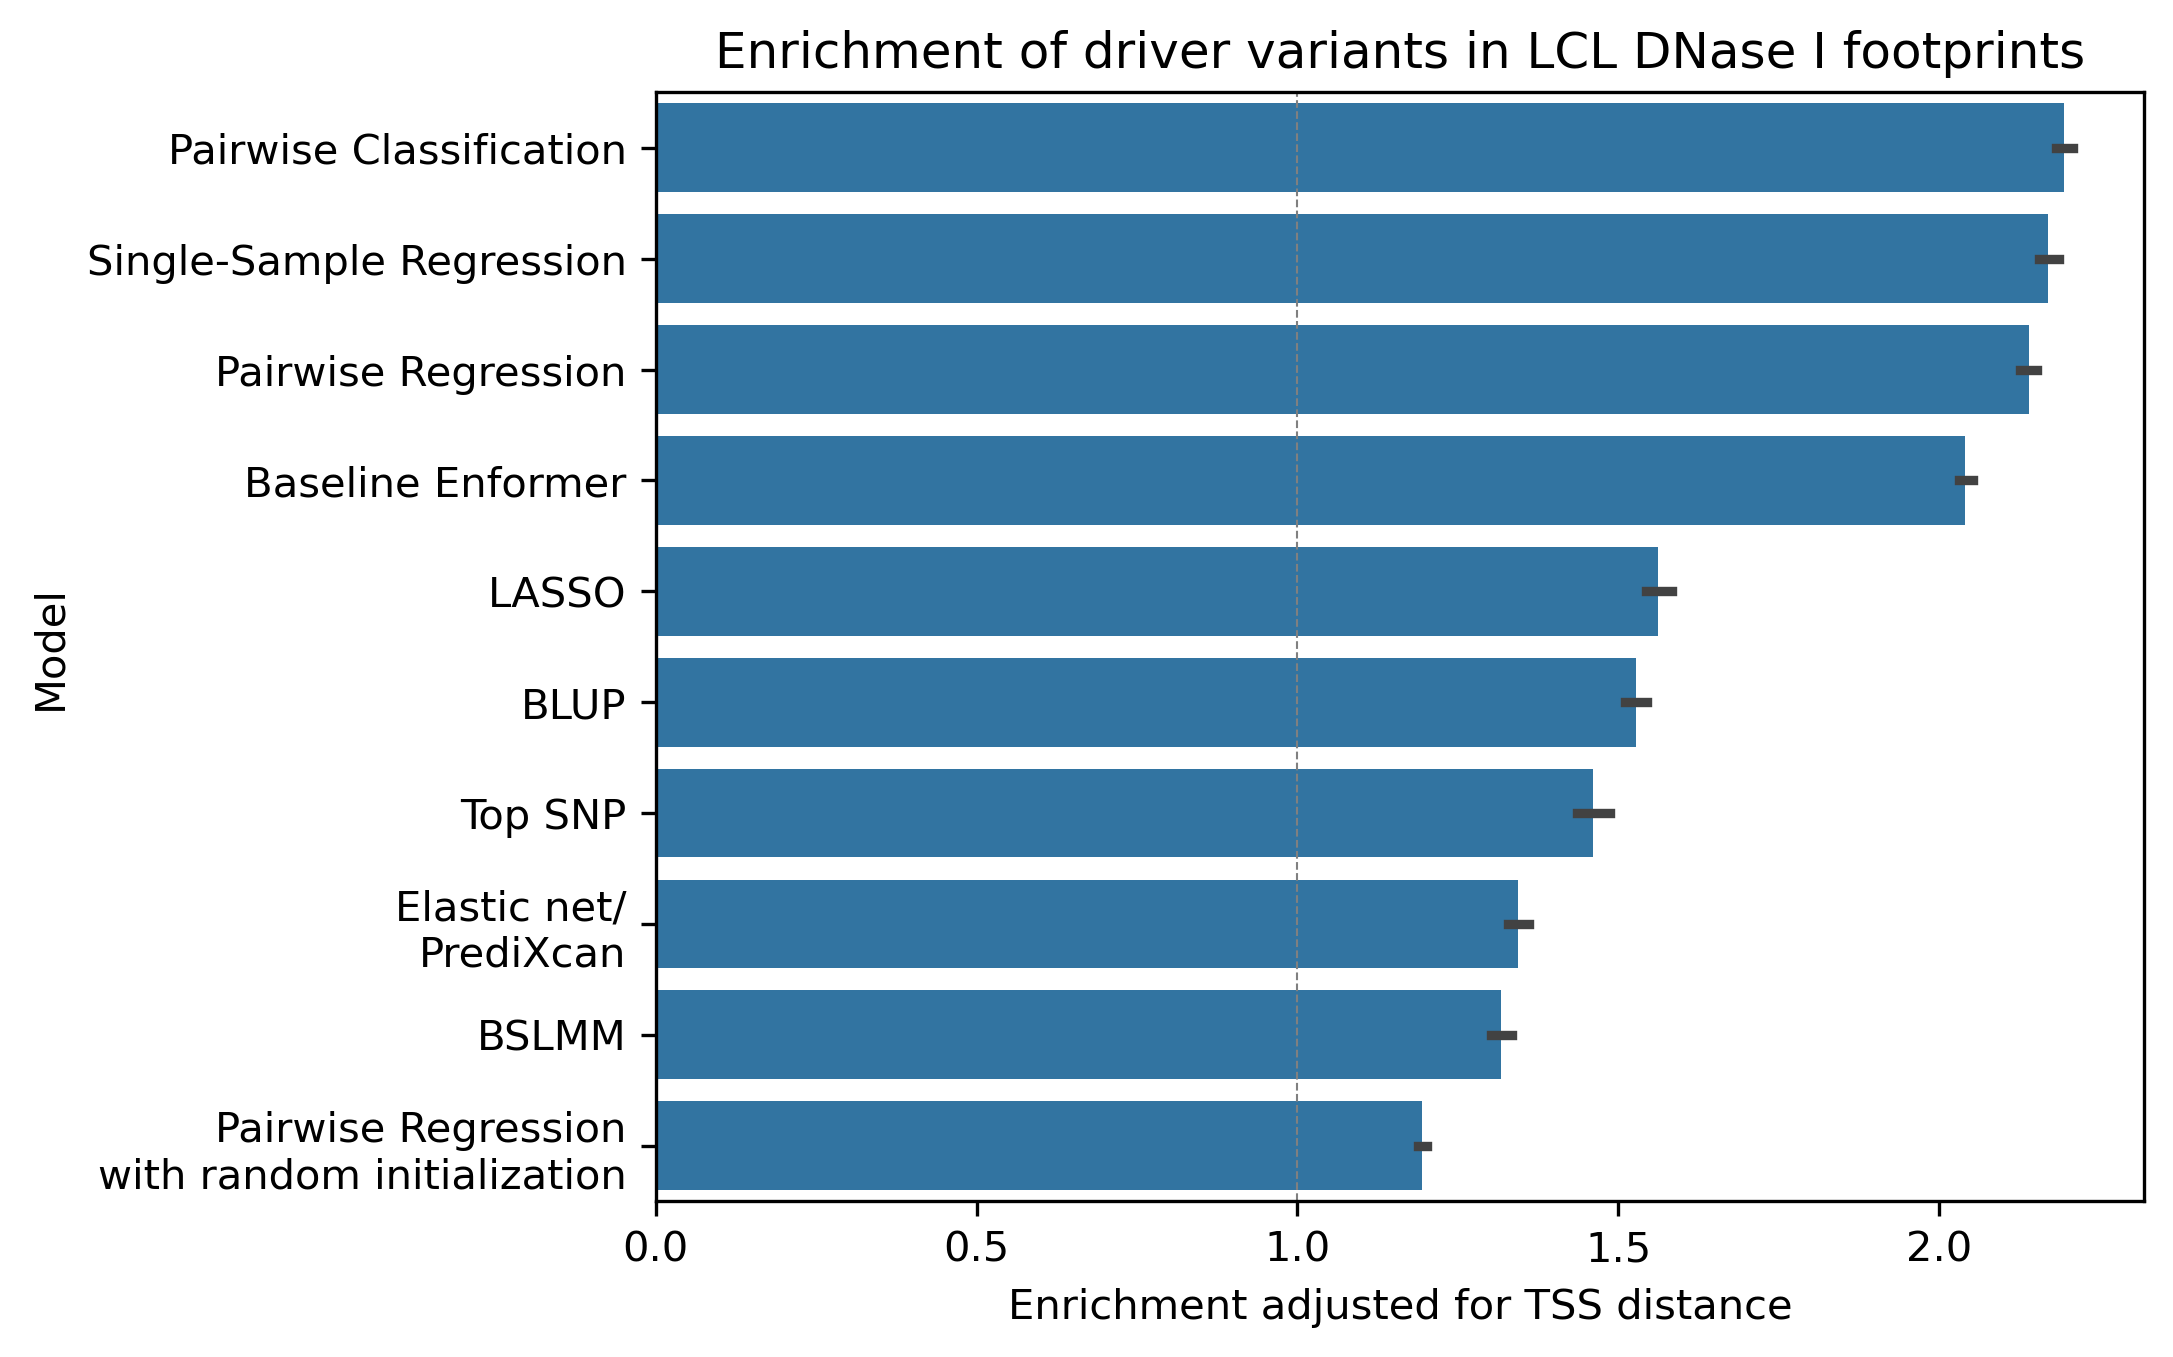

In [14]:
fig, ax = plt.subplots(dpi=300)

# Order models by mean enrichment
yorder = results_df.groupby("model")["enrichment"].mean().sort_values(ascending=False).index

sns.barplot(
    data=results_df,
    y="model",
    x="enrichment",
    order=yorder,
    estimator="mean",
    errorbar=("ci", 95),
    ax=ax,
)

ax.axvline(x=1.0, color="gray", linestyle="--", lw=0.5)
ax.set_xlabel("Enrichment adjusted for TSS distance")
ax.set_ylabel("Model")
ax.set_title("Enrichment of driver variants in LCL DNase I footprints")
plt.show()

In [15]:
results_df.to_csv("dnase1_enrichment.csv", index=False)